In [1]:
!pip install torchinfo
!pip install datasets
!pip install transformers
!pip install wandb
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from datasets import Dataset , load_dataset
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


In [ ]:
import wandb

wandb.login(key="wandb")


In [74]:
df = pd.read_csv('data.csv')

In [75]:
df

,Unnamed: 0,reviews.text,label
0,0,My son loves his kindle fire tablet. It is per...,Positive
1,1,"This tablet does what it supposed to do, howev...",Neutral
2,2,Its a great tablet for the basics that my gran...,Positive
3,3,I don't feel Amazon brand batteries are as pow...,Neutral
4,4,The products that it was delivered but I could...,Negative
...,...,...,...
20455,2785,I find it difficult to navigate. I also have a...,Neutral
20456,2786,I don't play games on my tablet.,Neutral
20457,2787,I bought this as a Christmas gift for my wife ...,Neutral
20458,2788,My daughter has had this tablet for almost 2 m...,Neutral


In [76]:
df=df[['reviews.text','label']]

In [77]:
df.rename(columns={'reviews.text': 'text','label':'label'}, inplace=True)

In [78]:
df.dropna(inplace=True)

In [79]:
df.drop_duplicates(inplace=True)

In [80]:
target_map = { 'Positive': 1, 'Negative': 0, 'Neutral': 2}
df['target'] = df['label'].map(target_map)

In [81]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data1.csv', index = False)

In [82]:
raw_dataset = load_dataset('csv', data_files = 'data1.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [83]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)


In [15]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [84]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [85]:
tokenized_dataset = split.map(tokenize_fn, batched = True)


Map:   0%|          | 0/13190 [00:00<?, ? examples/s]

Map:   0%|          | 0/3298 [00:00<?, ? examples/s]

In [86]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [88]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)


Total number of parameters: 108312579


In [89]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=2,
                                  per_device_train_batch_size=80,
                                  per_device_eval_batch_size=64,
                                  )

In [90]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [91]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

In [92]:
tokenized_dataset["train"]

Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13190
})

In [93]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.457431,0.818678,0.818678
2,No log,0.420438,0.838993,0.838993


TrainOutput(global_step=330, training_loss=0.4660406401663115, metrics={'train_runtime': 236.1031, 'train_samples_per_second': 111.731, 'train_steps_per_second': 1.398, 'total_flos': 3178708144322760.0, 'train_loss': 0.4660406401663115, 'epoch': 2.0})

In [94]:
pred_results = trainer.predict(tokenized_dataset["test"])
logits = pred_results.predictions         # مصفوفة التنبؤات (logits)
y_true = pred_results.label_ids            # التصنيفات الحقيقية
y_pred = np.argmax(logits, axis=1)           # تحويل logits إلى تصنيفات (اختيار أعلى قيمة)

# حساب المقاييس الإجمالية
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')


In [95]:

print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("Macro-average Precision: {:.2f}%".format(precision * 100))
print("Macro-average Recall: {:.2f}%".format(recall * 100))
print("Macro-average F1 Score: {:.2f}%".format(f1 * 100))

Overall Accuracy: 83.90%
Macro-average Precision: 80.40%
Macro-average Recall: 79.97%
Macro-average F1 Score: 80.12%


In [96]:
target_names = ["Negative", "Positive", "Neutral"]
report = classification_report(y_true, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)



Classification Report:

              precision    recall  f1-score   support

    Negative       0.83      0.78      0.80       667
    Positive       0.92      0.91      0.91      1887
     Neutral       0.66      0.71      0.69       744

    accuracy                           0.84      3298
   macro avg       0.80      0.80      0.80      3298
weighted avg       0.84      0.84      0.84      3298



In [97]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 517   31  119]
 [  18 1720  149]
 [  86  128  530]]


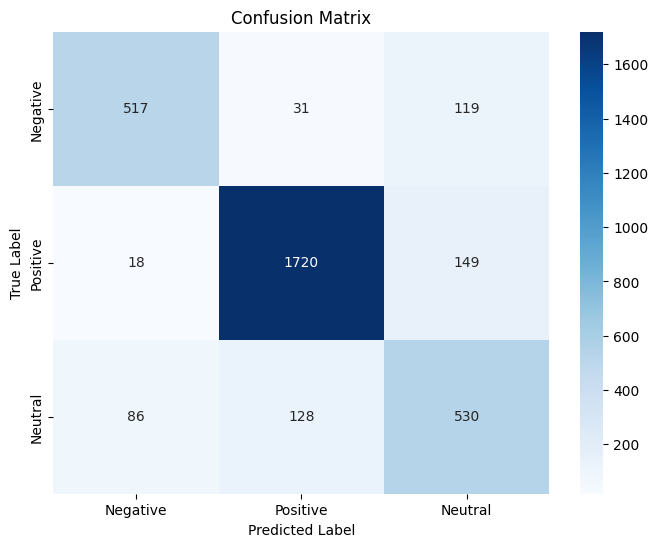

In [98]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# model.save_pretrained("model")
tokernizer.save_pretrained("transforms_fine_tuning2")
model.save_pretrained("transforms_fine_tuning2")


('transforms_fine_tuning2/tokenizer_config.json',
 'transforms_fine_tuning2/special_tokens_map.json',
 'transforms_fine_tuning2/vocab.txt',
 'transforms_fine_tuning2/added_tokens.json',
 'transforms_fine_tuning2/tokenizer.json')

In [100]:
ls


data1.csv       sample_data/              transforms_fine_tuning1.zip
data.csv        training_dir/             transforms_fine_tuning2/
larg_model/     transforms_fine_tuning/   transforms_fine_tuning.zip
larg_model.zip  transforms_fine_tuning1/  wandb/


In [101]:
import shutil

shutil.make_archive("transforms_fine_tuning2", 'zip', "transforms_fine_tuning2")

'/content/transforms_fine_tuning2.zip'